# Chapter 1: ECG data smoothing and filtering  

Most sensor data is affected to some extent by noise. In this tutorial, we show you a noisy ECG signal and describe several techniques to remove noise from the signal. These techniques are also described in the corresponding chapter.

In [1]:
import glob
import matplotlib
from matplotlib import cm
import sys
import math
import numpy as np
import pandas as pd
import pylab as pl
from biosppy.signals import ecg
from scipy import signal

import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz, iirnotch, filtfilt, firwin

matplotlib.style.use('ggplot')
%matplotlib notebook
import mpld3
mpld3.enable_notebook()

## Noisy ECG signals

In this example, we will look at removing noise from an ECG trace. This signal is a Lead I ECG signal acquired at 1000 Hz, with a resolution of 12 bit. Although of good quality, it exhibits powerline noise interference, has an offset resulting from the acquisition device, and we can also observe the influence of breathing in the variability of peak amplitudes.

<IPython.core.display.Javascript object>


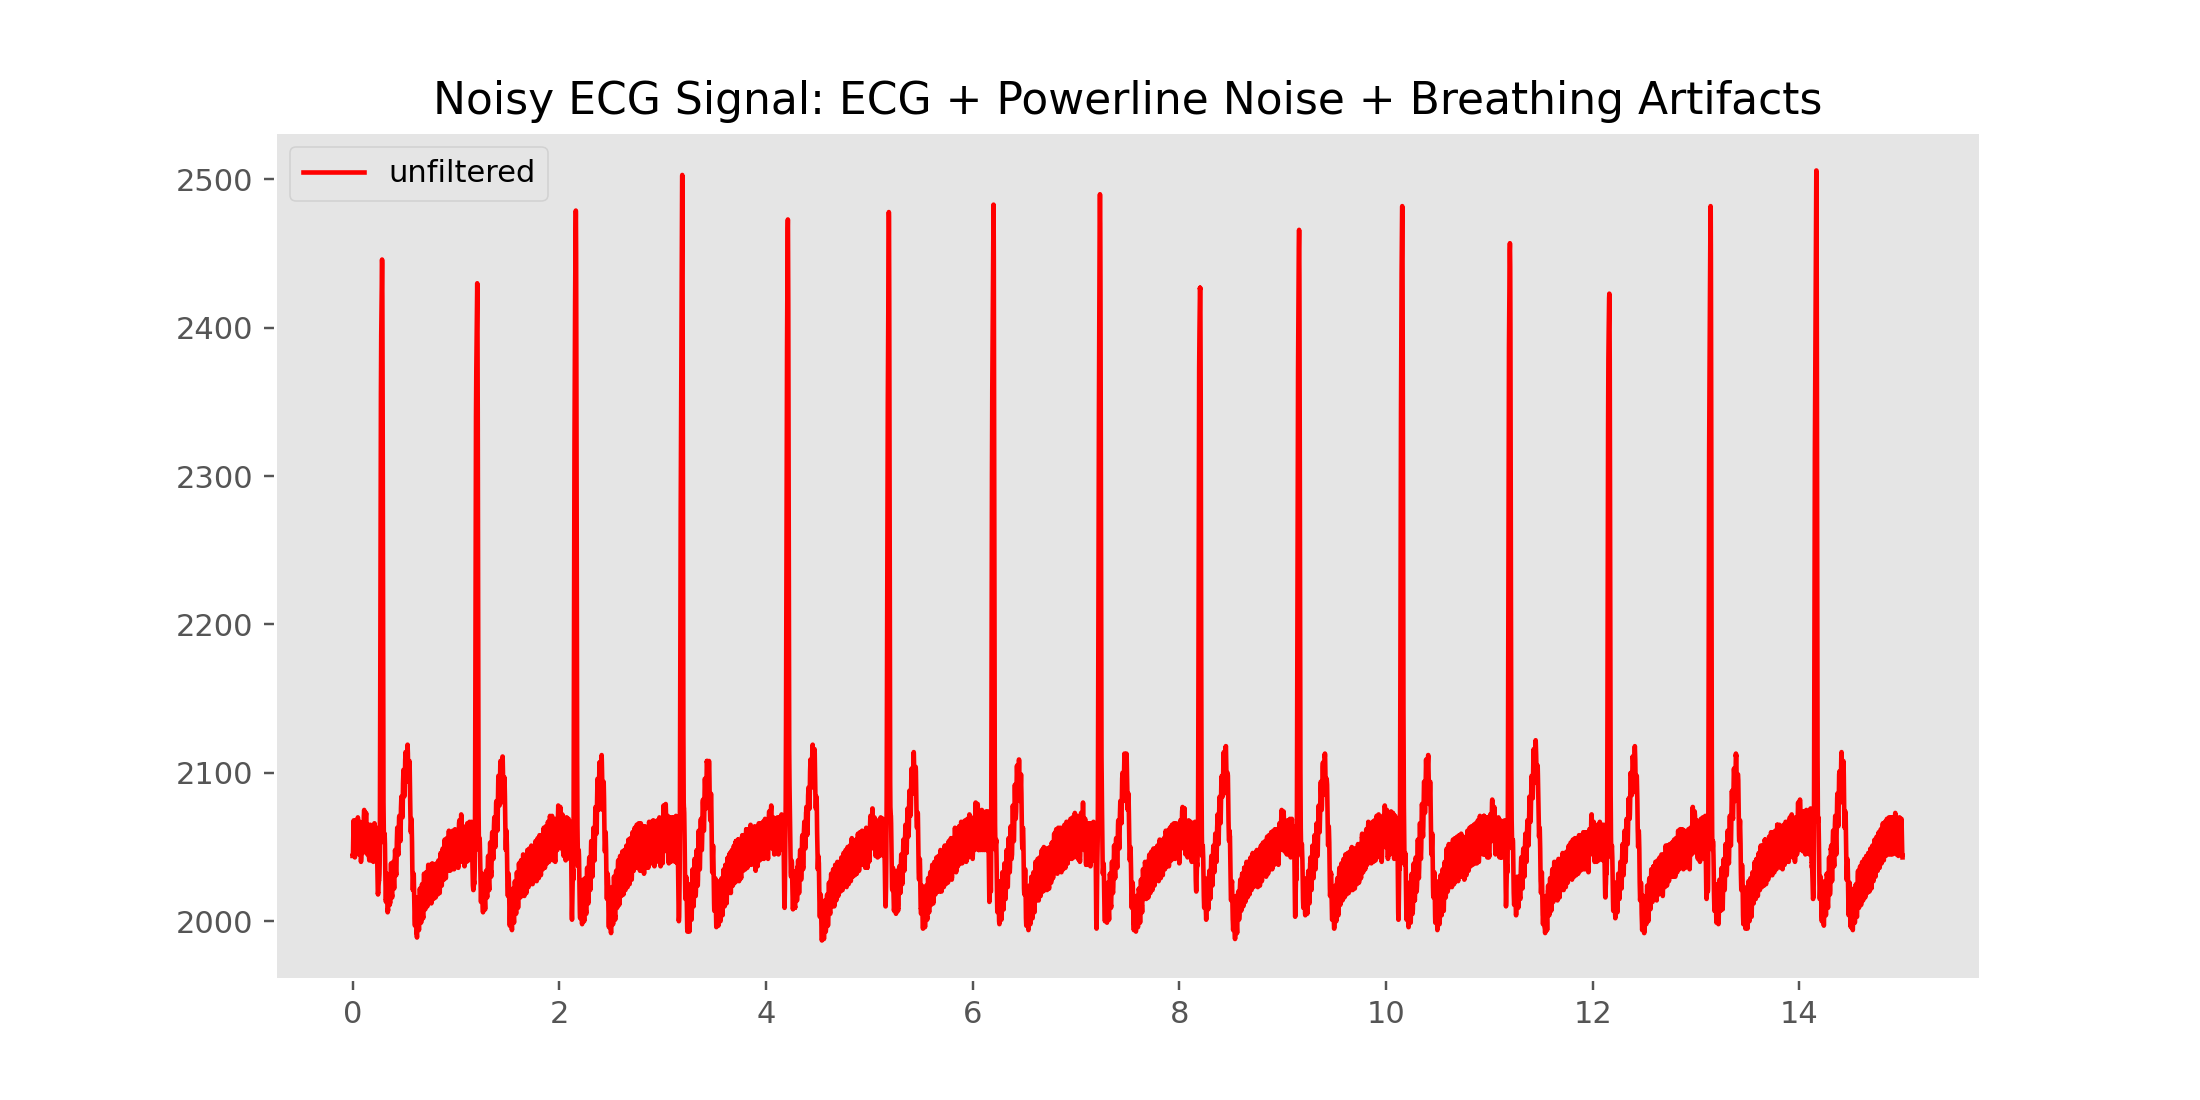

In [2]:
plt.figure(figsize=(10,5))
signal = np.loadtxt('data/ECG-Trace/ecg.txt')
sampling_rate =1000
N = len(signal) # number of samples
T = (N - 1) / sampling_rate # duration
ts = np.linspace(0, T, N, endpoint=False) # relative timestamps
pl.plot(ts, signal, 'r-',label='unfiltered')
plt.title("Noisy ECG Signal: ECG + Powerline Noise + Breathing Artifacts")
pl.legend(loc='upper left')
pl.grid()
pl.show()

### Moving Average Filter

We are going to try to smooth ECG with a simple moving average filter. But since the noise is due to periodic signals like powerline interference and breathing, moving average is not effective.

<IPython.core.display.Javascript object>


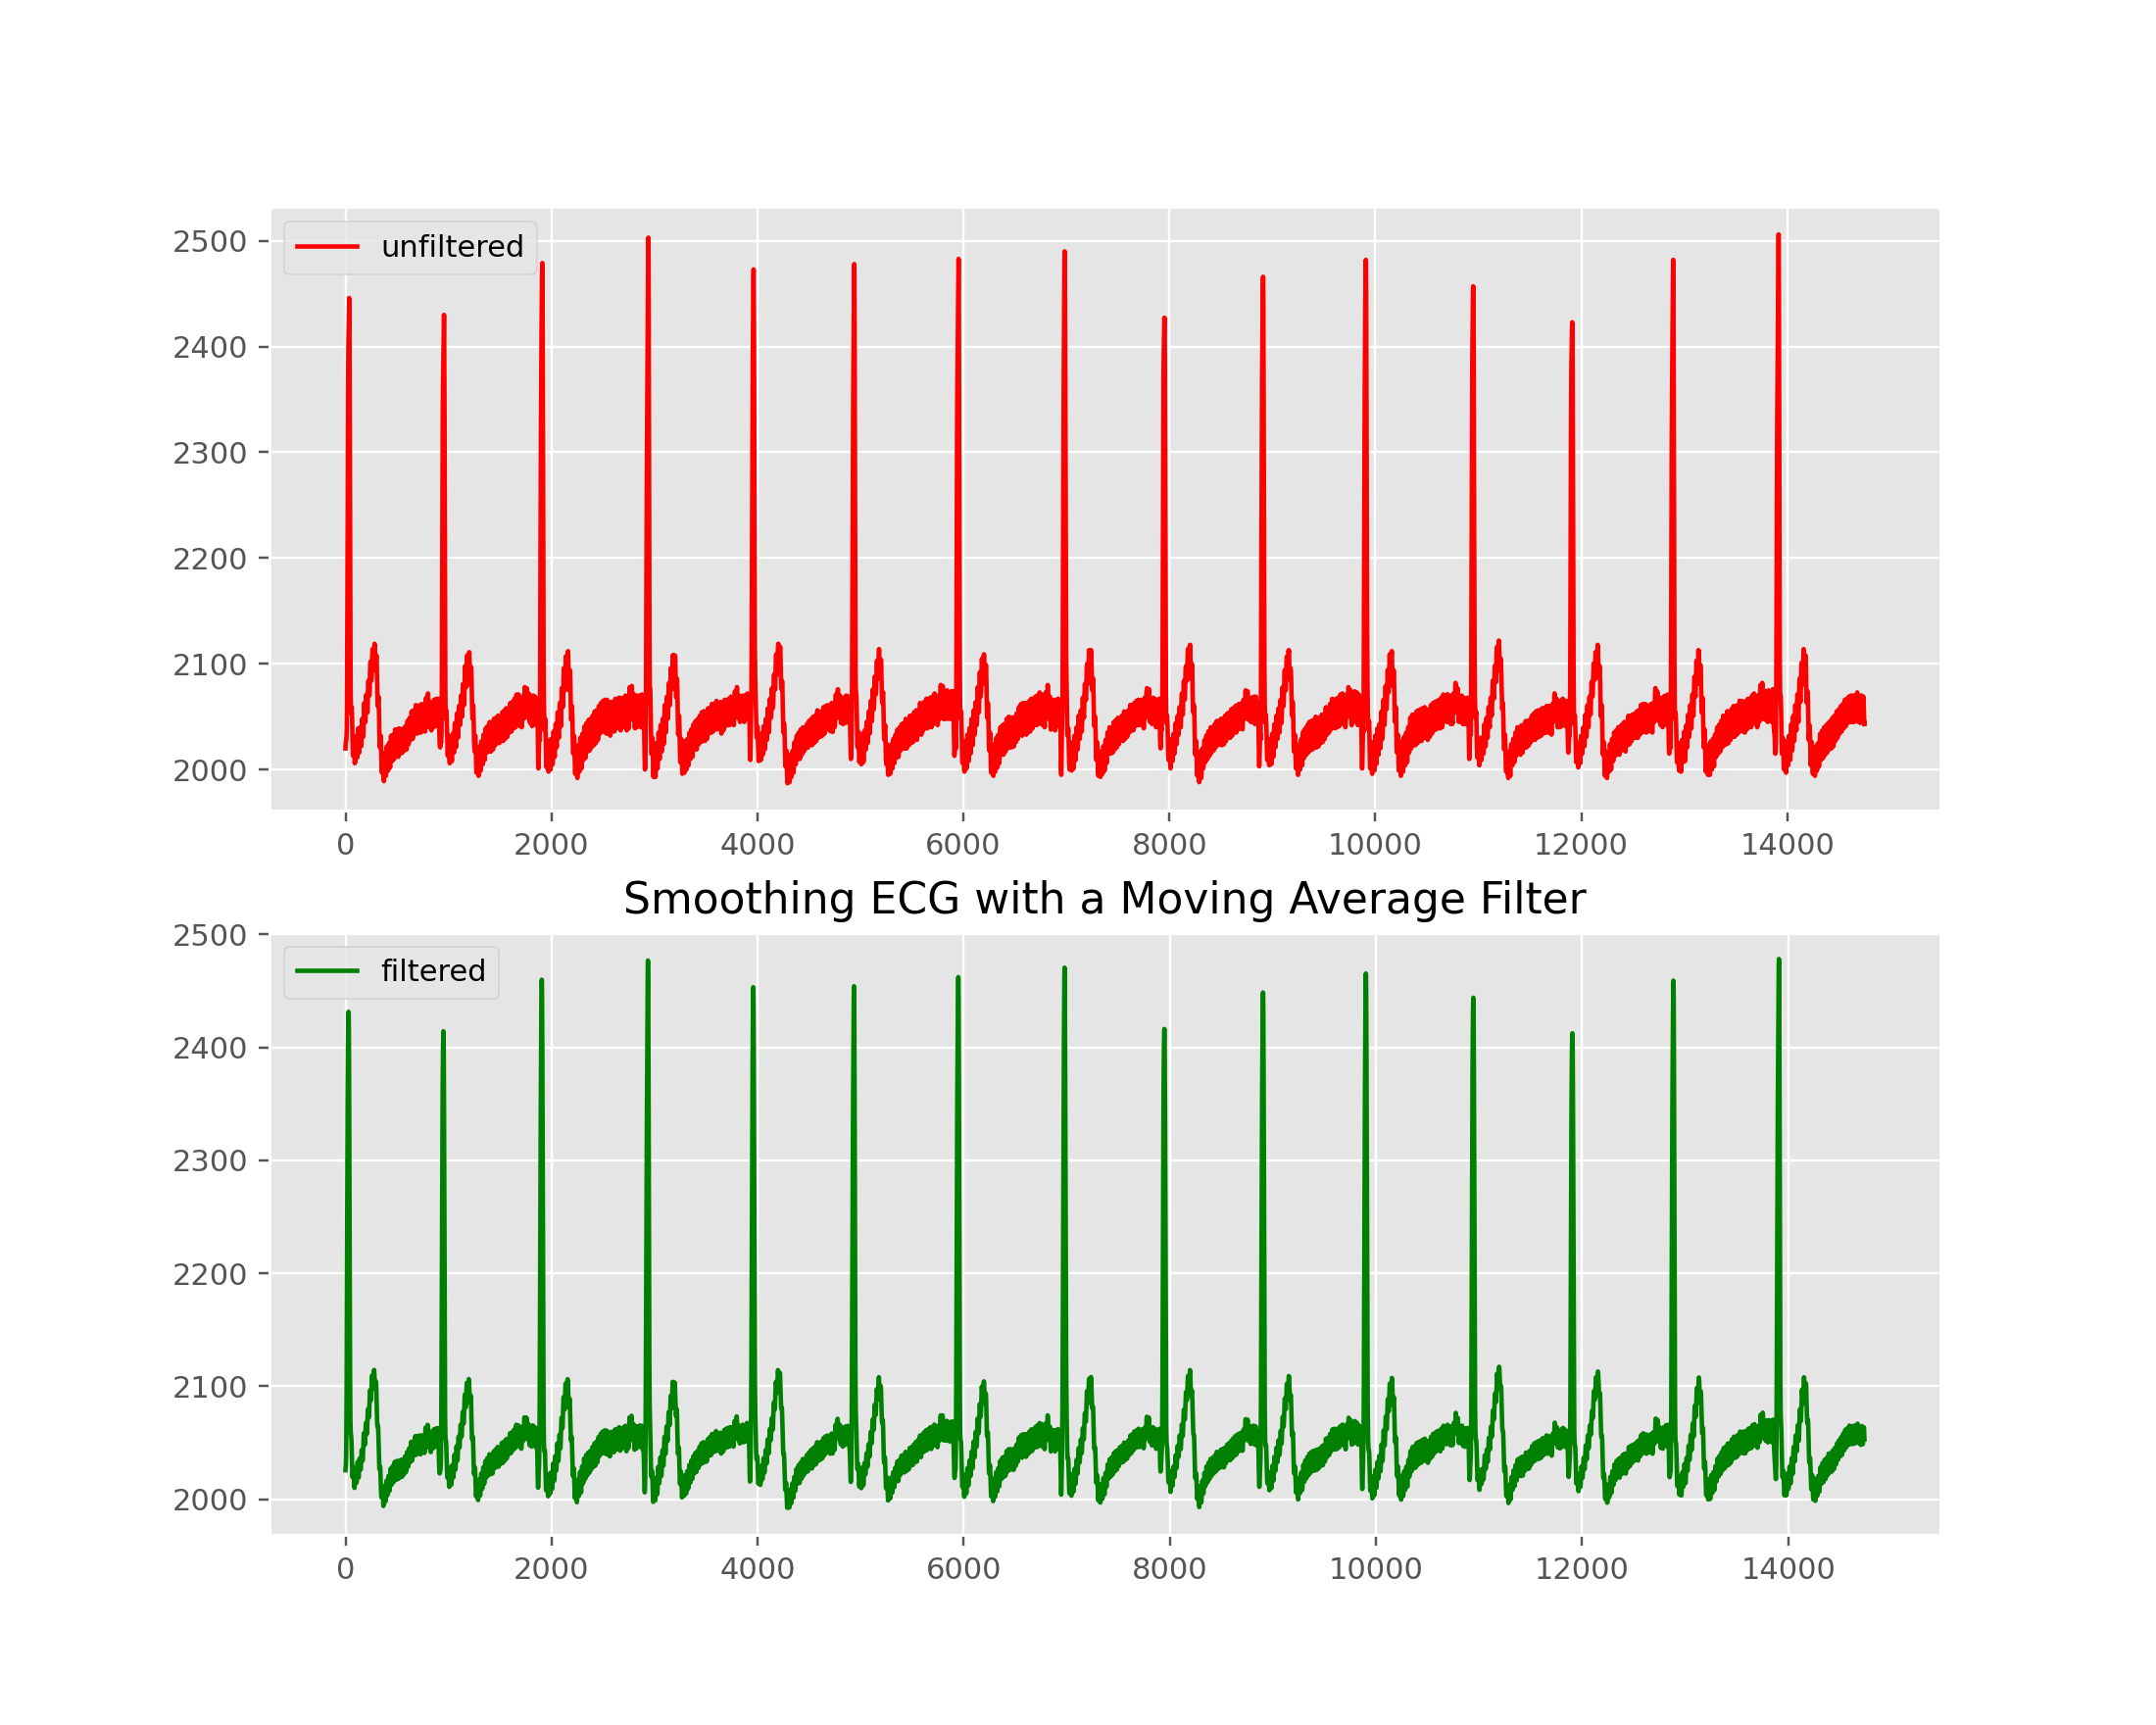

In [3]:
# Moving average with window size
window_size = 10
filtered_signal = np.convolve(signal, np.ones((window_size,))/window_size, mode='valid')

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(signal[250:], 'r-', label='unfiltered')
ax[0].legend(loc='upper left')
ax[1].plot(filtered_signal[250:], 'g-', linewidth=1.5, label='filtered')
ax[1].legend(loc='upper left')
ax[1].set_title("Smoothing ECG with a Moving Average Filter")
plt.show()


### Frequency-domain filtering

A classic example of how these frequency domain filters are used for noise removal is in the case of ECG filtering, so let us discuss how this works. There are three sources of noise in the ECG data shown above
* <b>Baseline Wander</b>: Baseline wander is a low-frequency component present in the ECG system which causes the signal to “wander” off from the actual ECG waveform.
* <b>Powerline Noise</b>: The frequency of alternating current in the electrical mains is typically around 50-60Hz. Since this is in the frequency range of the ECG signal that we are interested in, it appears as a significant source of noise that can disrupt any measurement that we wish to make.
* <b>High frequency Noise</b>: Various other electronic equipment in the vicinity of the ECG sensor including pacemakers, mobile phones, and other electronics can interfere with the ECG signal. These sources of noise are high frequency, and need to be removed by an appropriately selected low-pass filter.

We will use the filtering pipeline shown below (see class notes). First, we will use a band pass filter to remove frequencies 0.5Hz and 150Hz, and then apply a notch filter that removes power line noise.

<img src="figures/ecg-filter-pipeline.png" width=700>

#### Band pass filter to remove baseline wander and high-frequency noise

We first apply a bandpass filter to remove all frequencies lower than 0.3Hz and higher than 150Hz. 

<IPython.core.display.Javascript object>


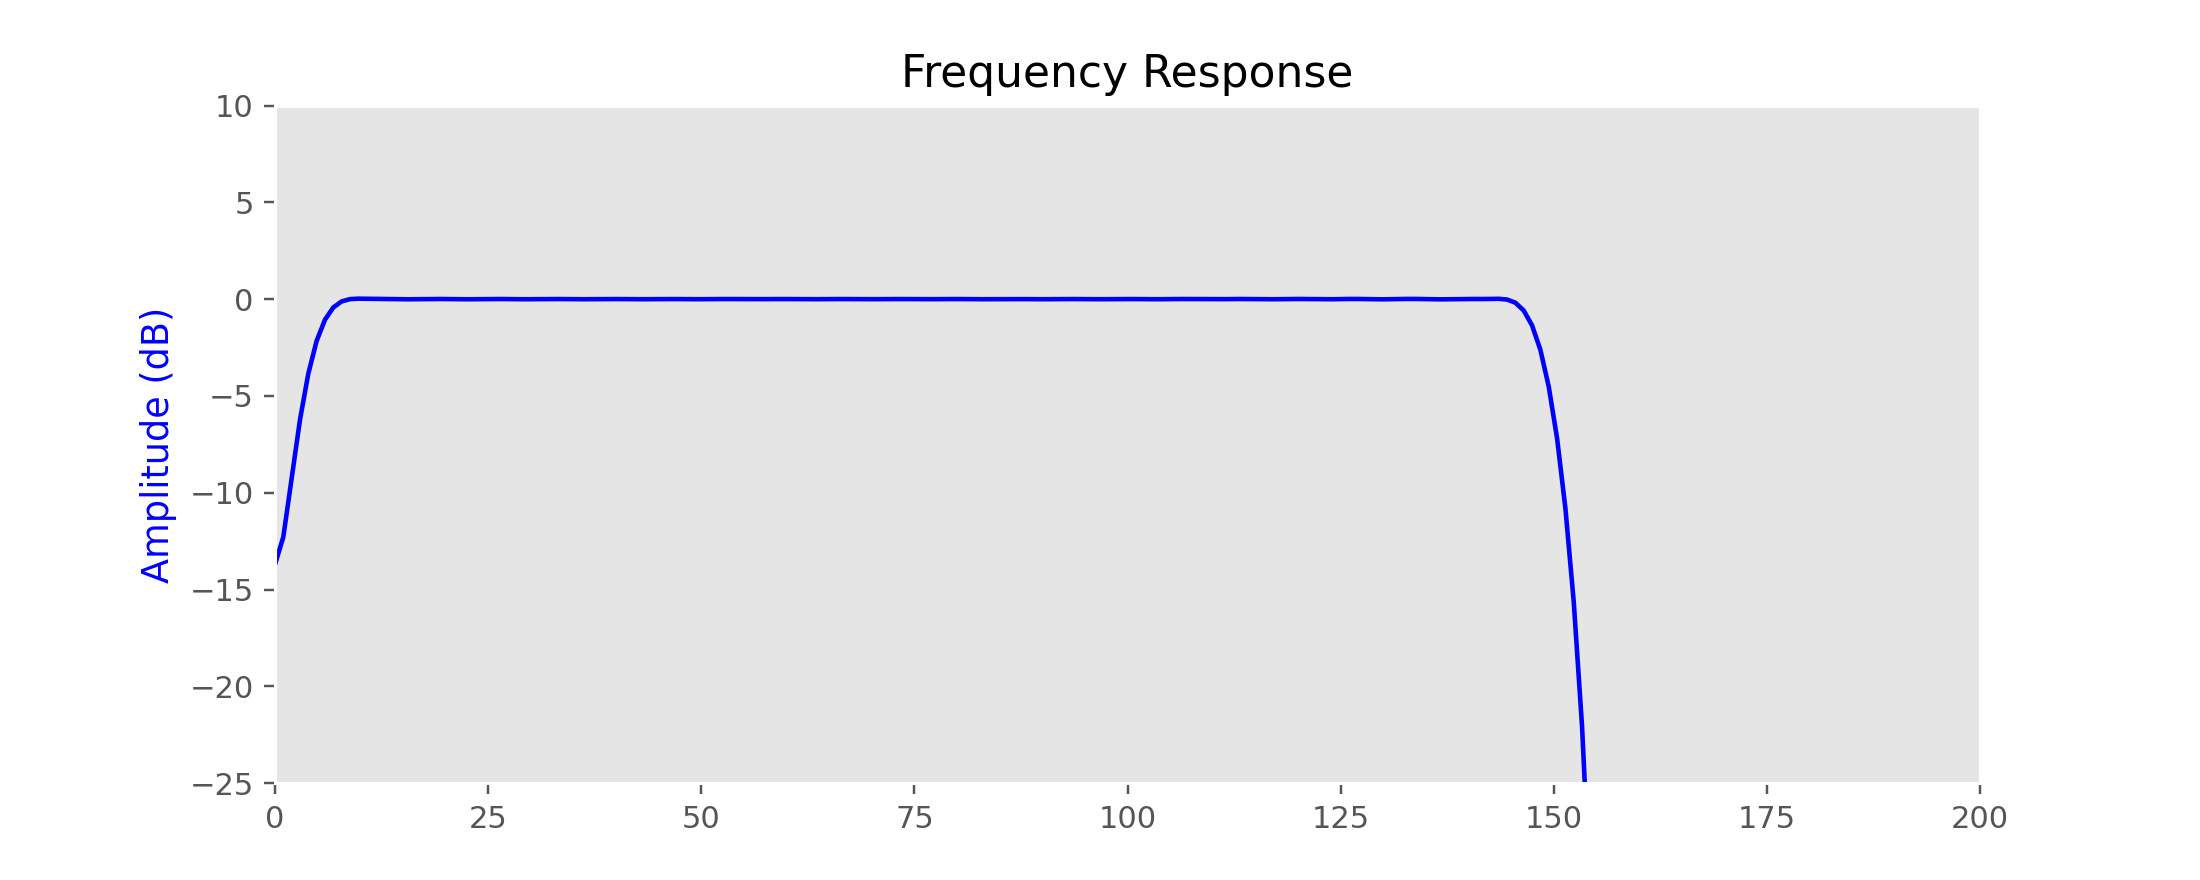

In [4]:
# remove baseline wander caused by breathing
fs = sampling_rate  # Sample frequency (Hz)
order = int(0.3 * sampling_rate)
if order % 2 == 0: order += 1

# the cutoff frequencies for the filter.
f1, f2 = 3, 150

# remember to normalize the frequencies to nyquist.
f1 = 2. * f1 / sampling_rate
f2 = 2. * f2 / sampling_rate

a = np.array([1])
b = firwin(order,[f1, f2],pass_zero=False)

# Frequency response
w, h = freqz(b, a)
# Generate frequency axis
freq = w*fs/(2*np.pi)
# Plot
plt.figure(figsize=(10,4))
plt.plot(freq, 20*np.log10(abs(h)), color='blue')
plt.title("Frequency Response")
plt.ylabel("Amplitude (dB)", color='blue')
plt.xlim([0, 200])
plt.ylim([-25, 10])
plt.grid()
plt.show()

The notch filter removes the 

<IPython.core.display.Javascript object>


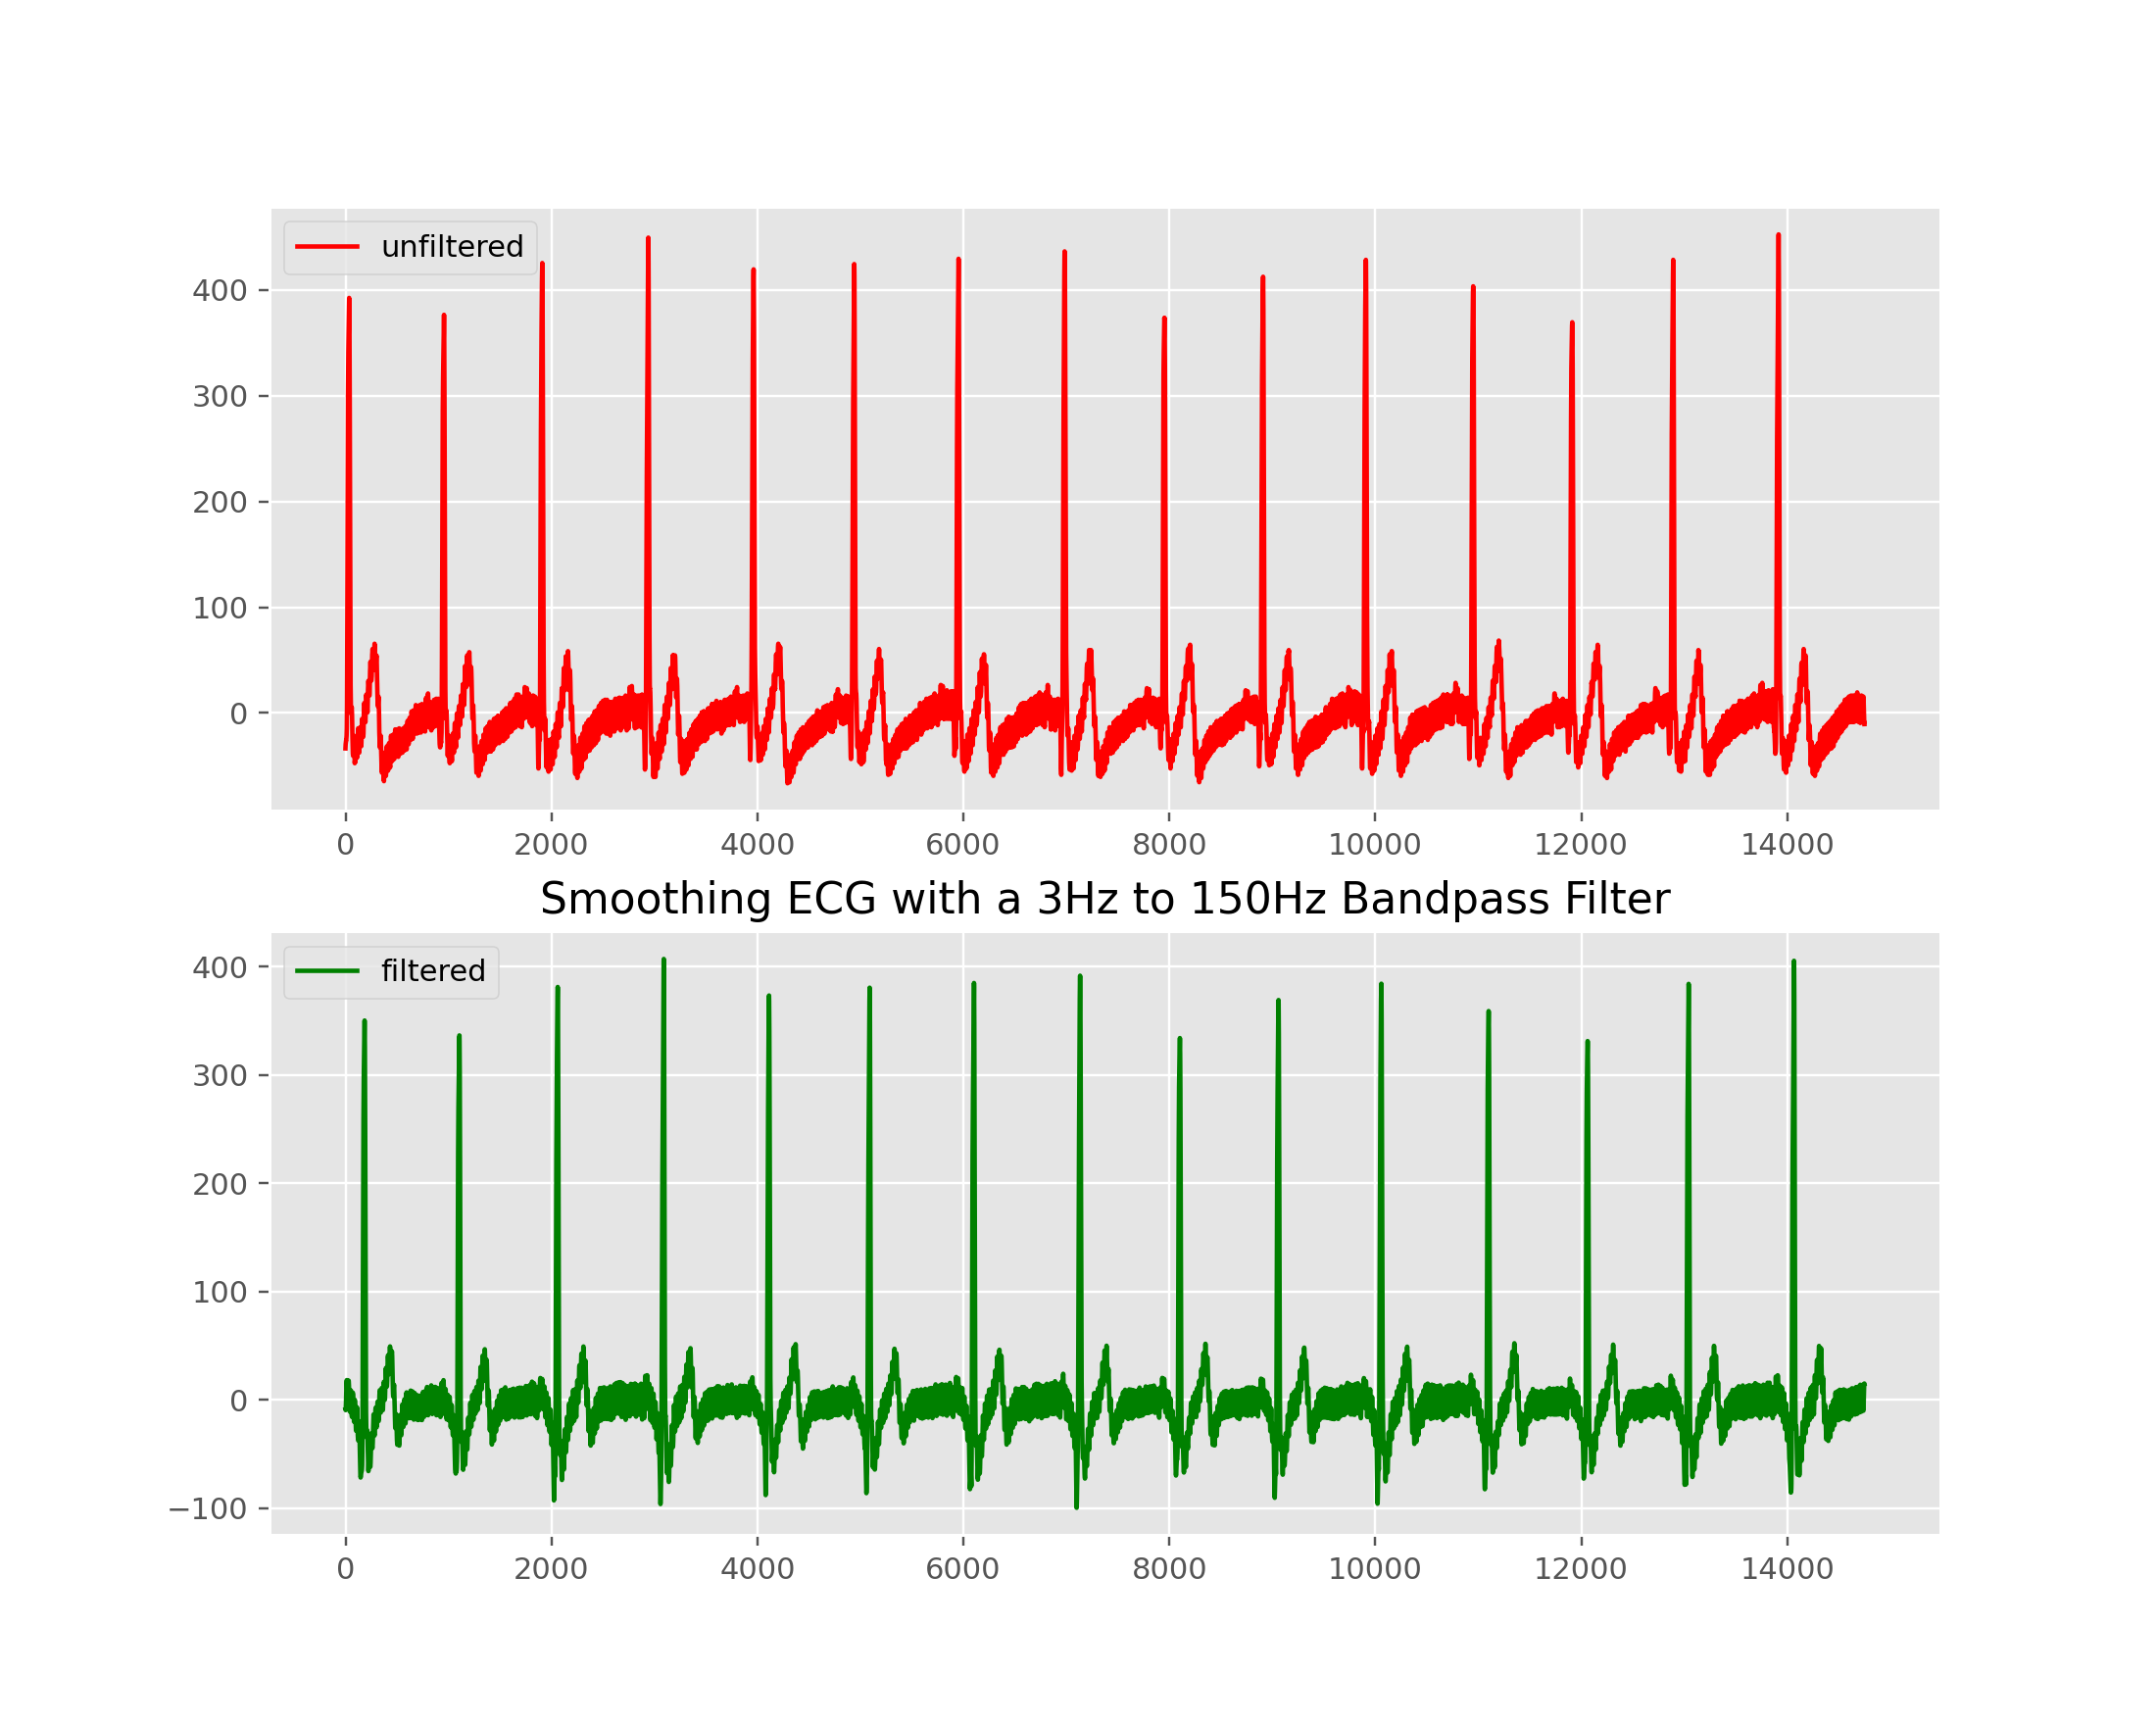

In [5]:
signal = signal - np.mean(signal)
bp_signal = lfilter(b, a, signal)

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(signal[250:], 'r-', label='unfiltered')
ax[0].legend(loc='upper left')
ax[1].plot(bp_signal[250:], 'g-', linewidth=1.5, label='filtered')
ax[1].set_title("Smoothing ECG with a 3Hz to 150Hz Bandpass Filter")
ax[1].legend(loc='upper left')
plt.show()

#### Notch filter to remove 50Hz noise

We will now remove powerline noise using a 50Hz notch filter.

In [6]:
fs = sampling_rate  # Sample frequency (Hz)
f0 = 50.0  # Frequency to be removed from signal (Hz)
Q = 8.0  # Quality factor
w0 = f0/(fs/2)  # Normalized Frequency
# Design notch filter
b, a = iirnotch(w0, Q)

<IPython.core.display.Javascript object>


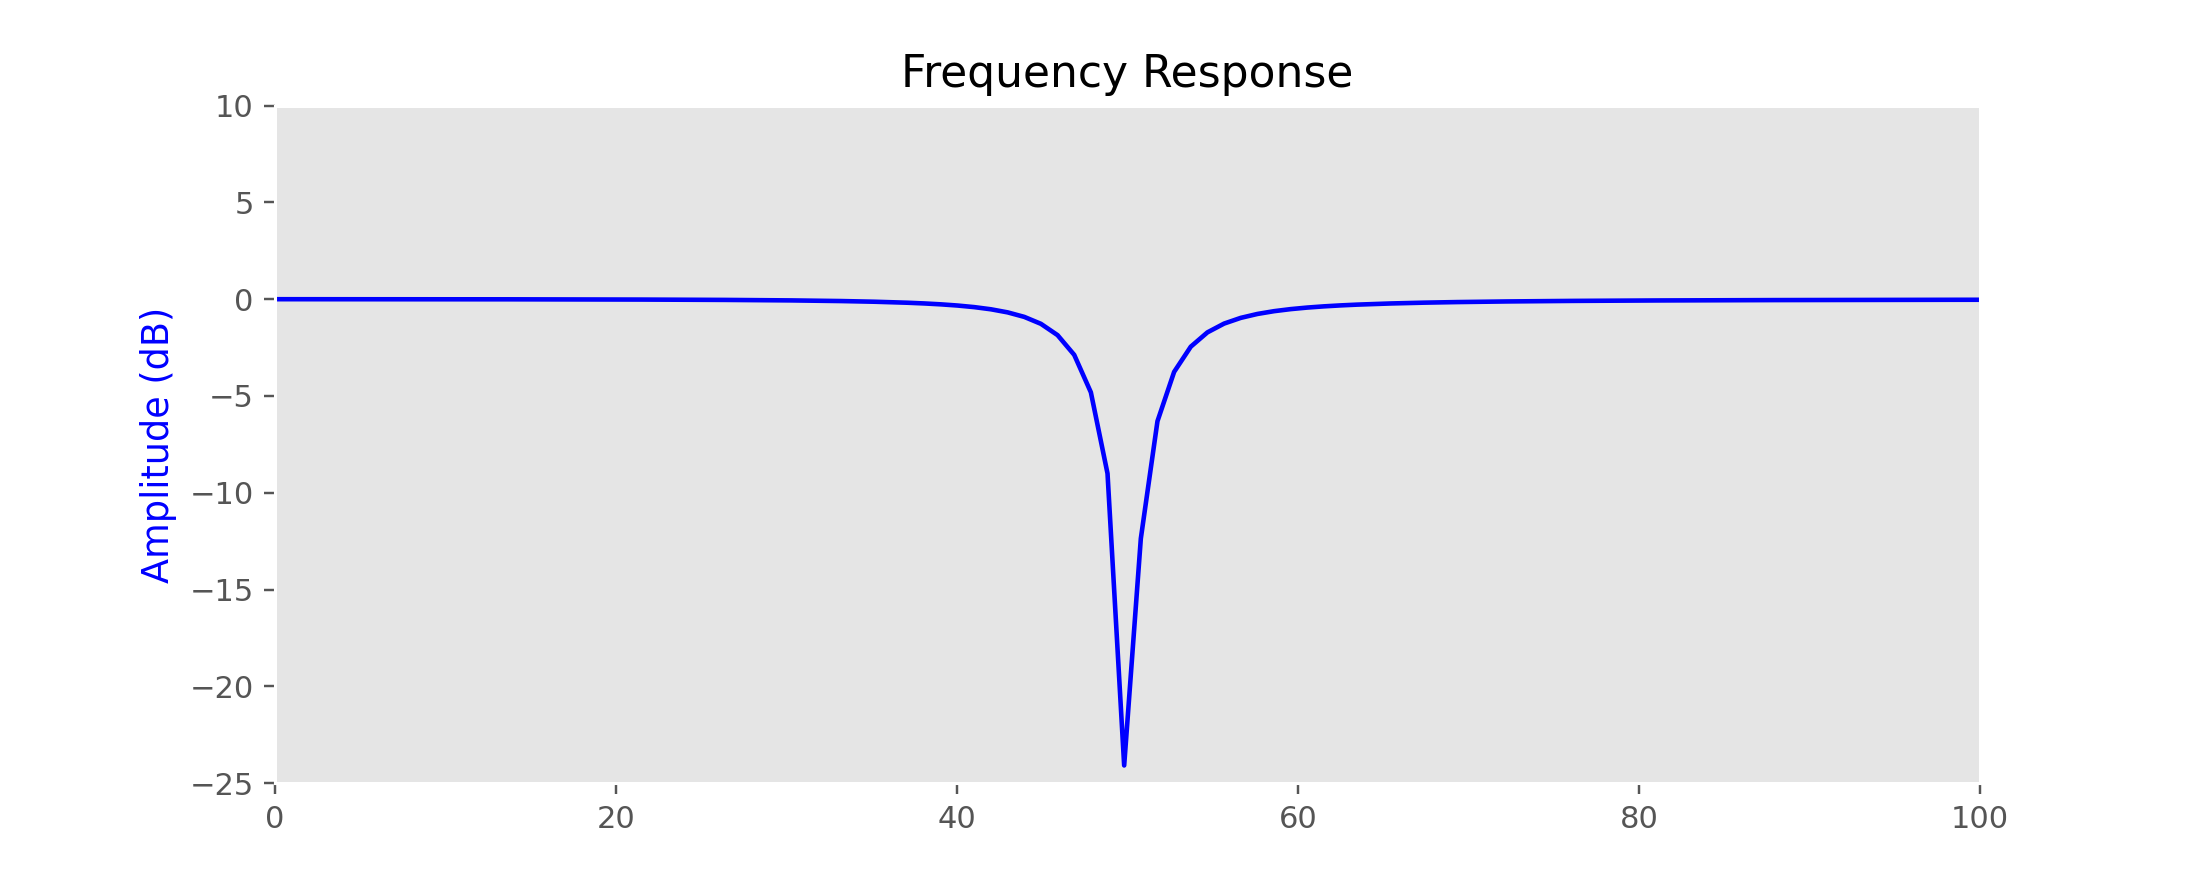

In [7]:
# Frequency response
w, h = freqz(b, a)
# Generate frequency axis
freq = w*fs/(2*np.pi)
# Plot
plt.figure(figsize=(10,4))
plt.plot(freq, 20*np.log10(abs(h)), color='blue')
plt.title("Frequency Response")
plt.ylabel("Amplitude (dB)", color='blue')
plt.xlim([0, 100])
plt.ylim([-25, 10])
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


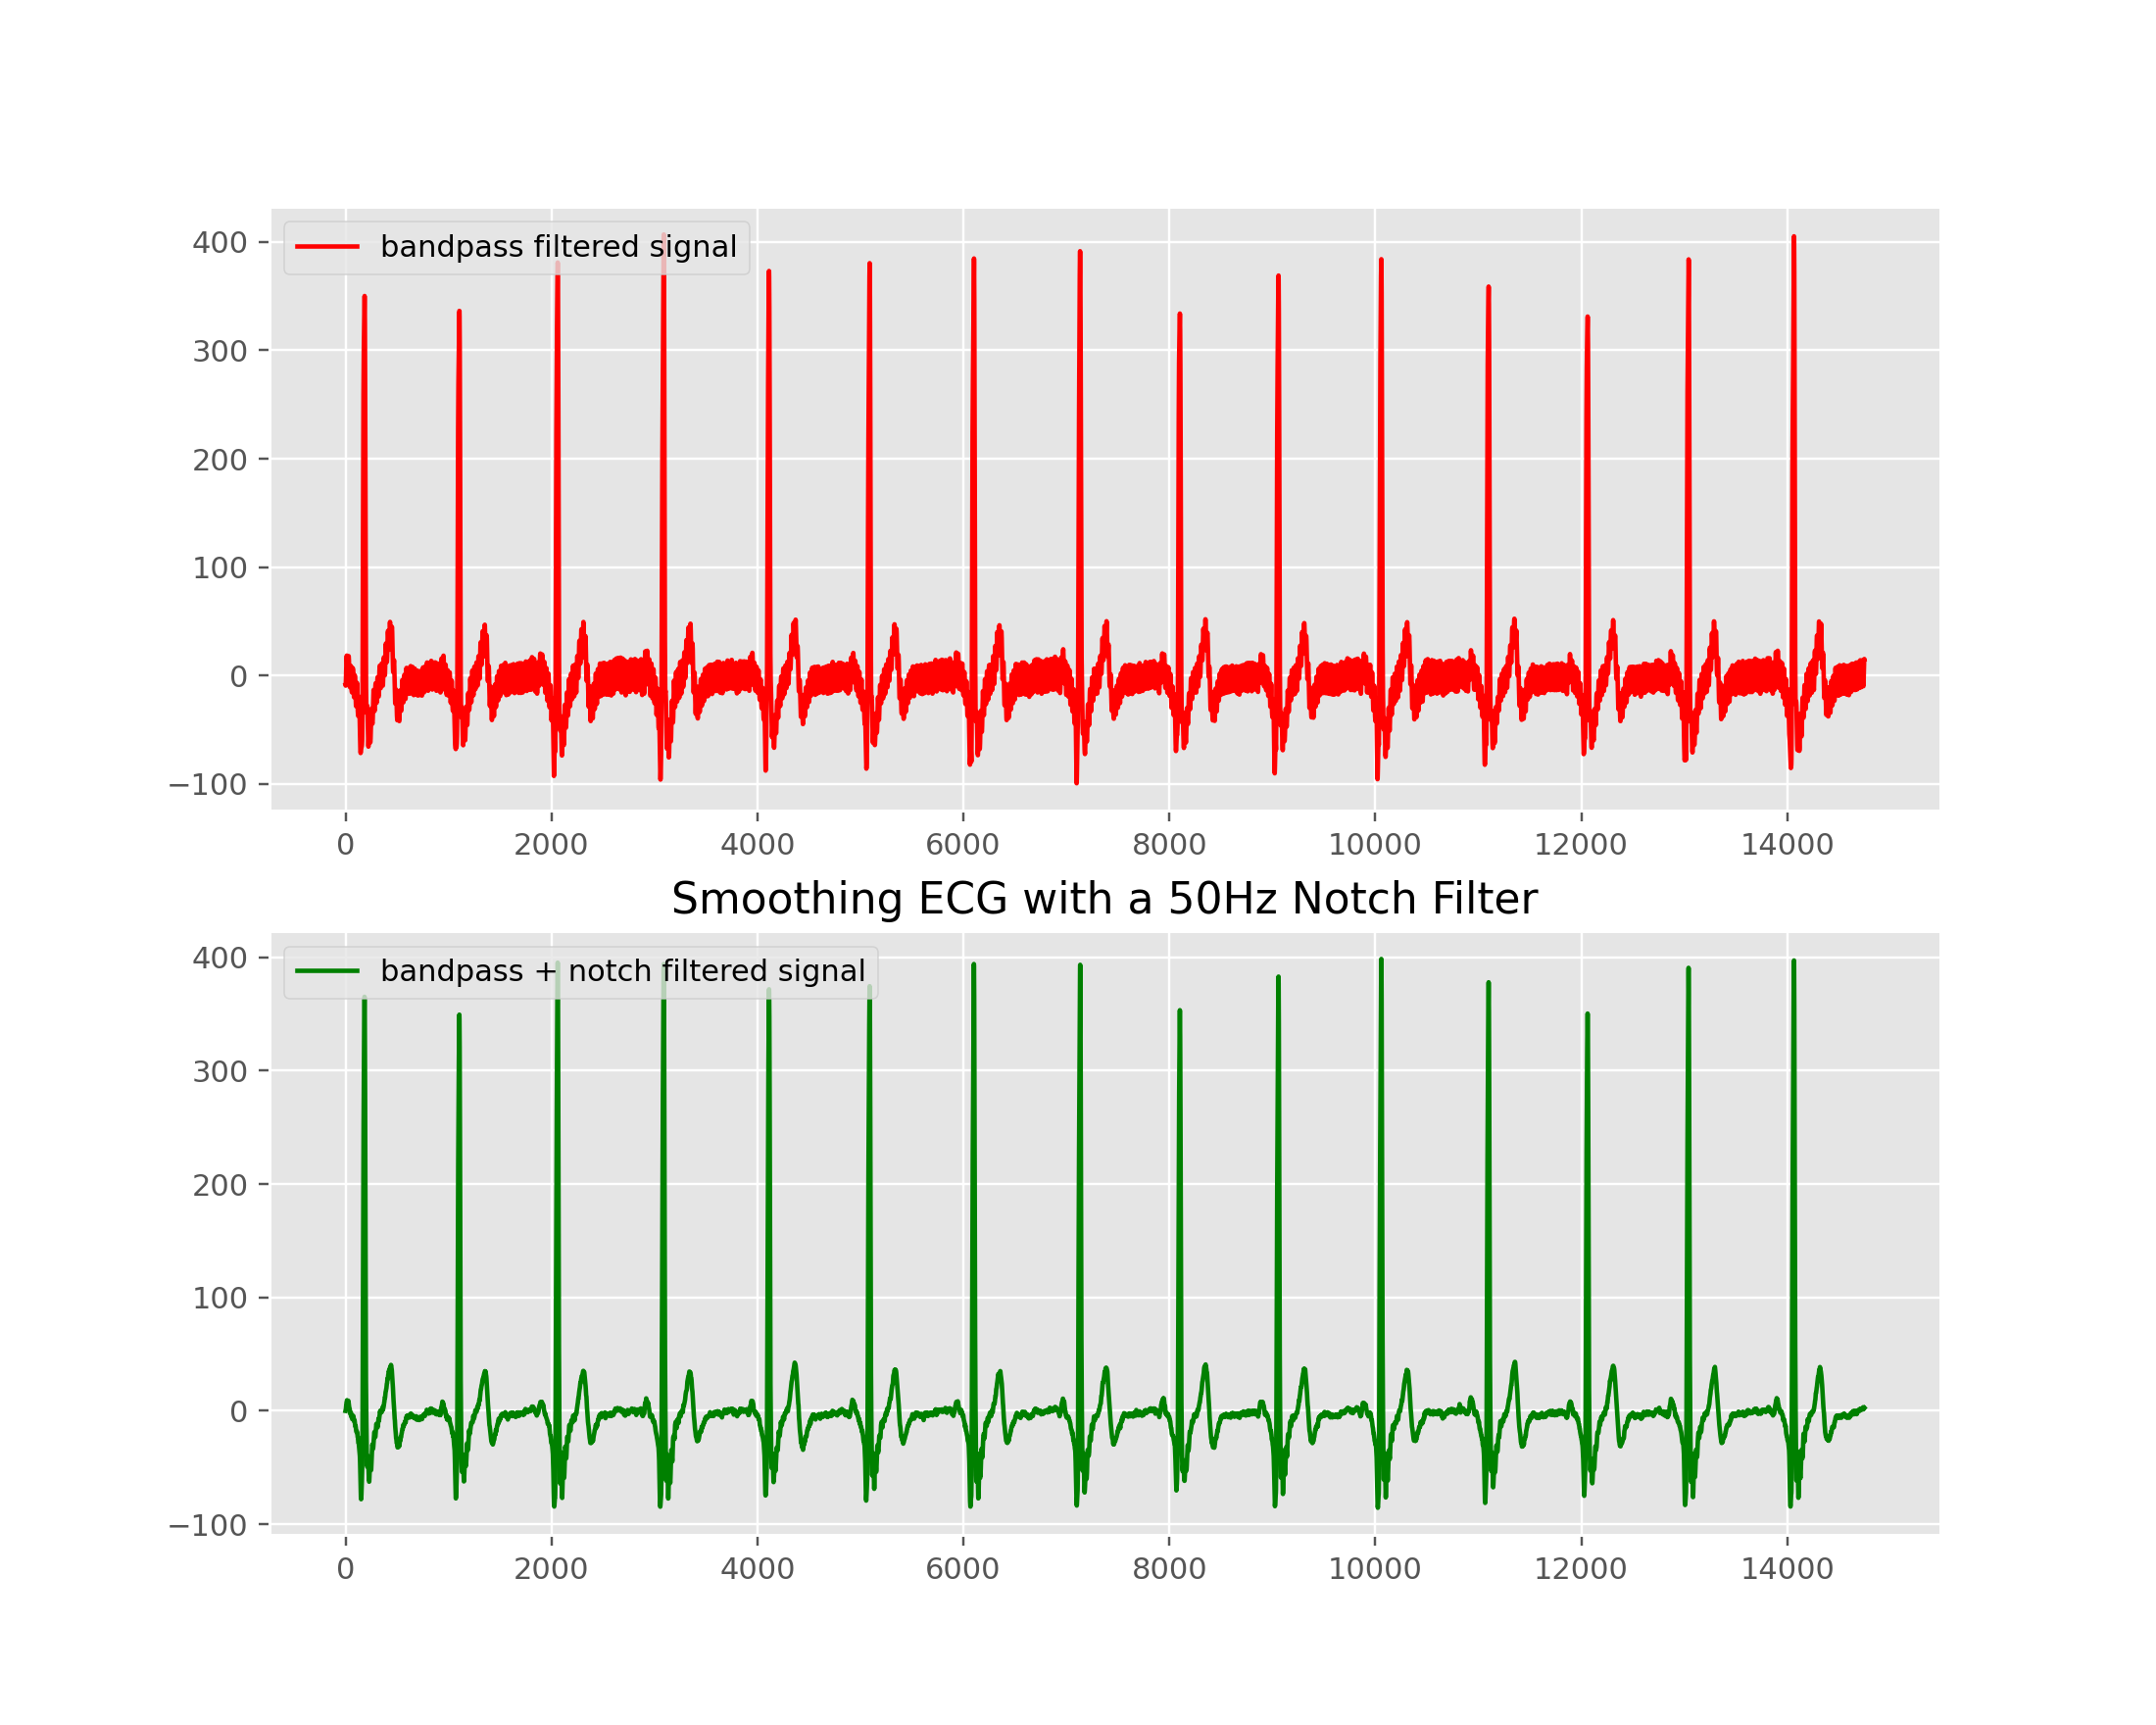

In [8]:
nf_signal = lfilter(b, a, bp_signal)
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(bp_signal[250:], 'r-', label='bandpass filtered signal')
ax[0].legend(loc='upper left')
ax[1].plot(nf_signal[250:], 'g-', linewidth=1.5, label='bandpass + notch filtered signal')
ax[1].set_title("Smoothing ECG with a 50Hz Notch Filter")
ax[1].legend(loc='upper left')
plt.show()
